# Data Challenge Number 3: Conversion Rate

The challenge is to figure out how the company can increase it's conversion rate.  The data we are expected to have includes country of user, their age, whether they registered as a new user, how they arrived at the site, the total number of pages they visited on the site and whether or not they made a purchase.

The goal is to be able to predict whether or not a user will make a purchase as well as to determine what the company might do to increase this likelihood.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [2]:
# Load in data
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
print 'The data has dimensions:',df.shape

The data has dimensions: (316200, 6)


# Data Exploration

The dataset is quite large.  The first step is to see how many different groupings there are in the data.  I will do this by building a few tables and histograms so that I have a better idea of the breakdown of customers.  

In [4]:
print df['country'].unique()
print df['source'].unique()
print df['total_pages_visited'].max()
print df['age'].min()
print df['age'].max()

['UK' 'US' 'China' 'Germany']
['Ads' 'Seo' 'Direct']
29
17
123


Hmmm, that age max has me a bit concerned.  It's a user entered value, so it's entirely possible that a substantial fraction of people enter ridiculously false ages.  Let me check that to see if this is a usable column.

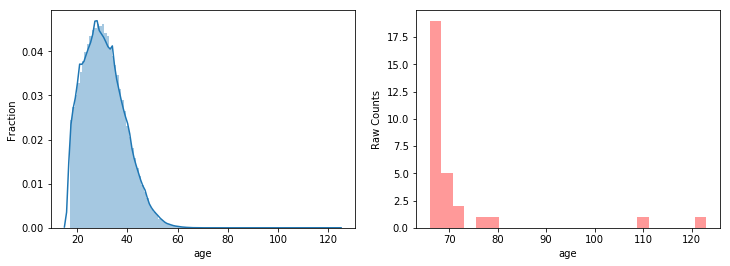

In [5]:
fig = plt.gcf()
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(1,2,1)
sns.distplot(df['age'], bins=108)
ax1.set_ylabel('Fraction')
ax2 = fig.add_subplot(1,2,2)
sns.distplot(df['age'].loc[(df['age'] > 65)], color = 'r', kde = False)
ax2.set_ylabel('Raw Counts')

OK, that is probably just one or two jokers and the column is fine to use.  Because the number is so small, it would probably be OK to elimate them, but for now I will leave them in.  Let's start to look at some additional breakdowns of the data.  Of particular concern to me initially is whether all markets should be analyzed together or separately.  To get an idea of this, I am going to break down the data by country for a few different metrics.

   country   total  converted      rate
0    China   76602        102  0.001332
1  Germany   13056        816  0.062500
2       UK   48450       2550  0.052632
3       US  178092       6732  0.037801


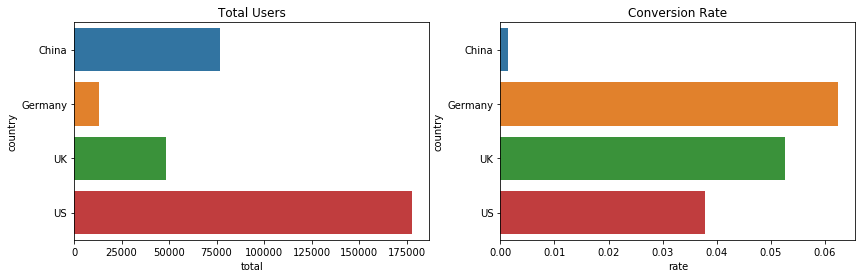

In [6]:
c_rate = pd.DataFrame()
gb = df.groupby(['country'])
c_rate = gb.agg({'age': 'count', 'converted': 'sum'}).rename(columns={'age':'total'})
c_rate.reset_index(inplace=True)
c_rate['rate']=(c_rate['converted']/c_rate['total'])
print c_rate

fig = plt.gcf()
fig.set_size_inches(14,4)
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x='total',y='country', data = c_rate)
ax1.set_title('Total Users')
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x='rate',y='country', data = c_rate)
ax2.set_title('Conversion Rate')

This makes me think that there is something fundamentally different about the markets and that they should be modeled independently.  Before I go down that road, let's look at a few other breakdowns by country.

In [7]:
def bins(data):
    bins = np.linspace(data.min(),data.max(),(data.max()-data.min()+1))
    return bins

def bins2(data):
    bins2 = np.linspace(data.min(),data.max(),(data.max()-data.min()+1)//2)
    return bins2

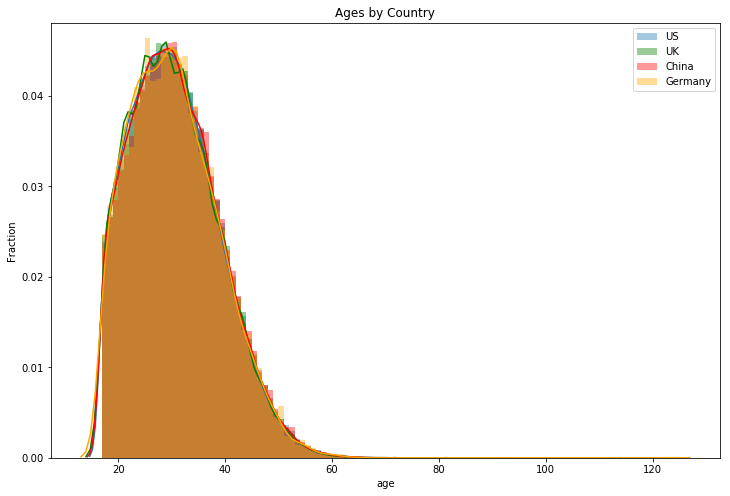

In [8]:
fig = plt.gcf()
fig.set_size_inches(12,8)
sns.distplot(df['age'].loc[(df['country'] == 'US')], bins=bins(df['age'].loc[df['country']=='US']),label='US')
sns.distplot(df['age'].loc[(df['country'] == 'UK')], bins = bins(df['age'].loc[df['country']=='UK']),color='g',label='UK')
sns.distplot(df['age'].loc[(df['country'] == 'China')], bins = bins(df['age'].loc[df['country']=='China']),color='r',label = 'China')
sns.distplot(df['age'].loc[(df['country'] == 'Germany')], bins = bins(df['age'].loc[df['country']=='Germany']),color='orange', label = 'Germany')
plt.ylabel('Fraction')
plt.title('Ages by Country')
plt.legend()


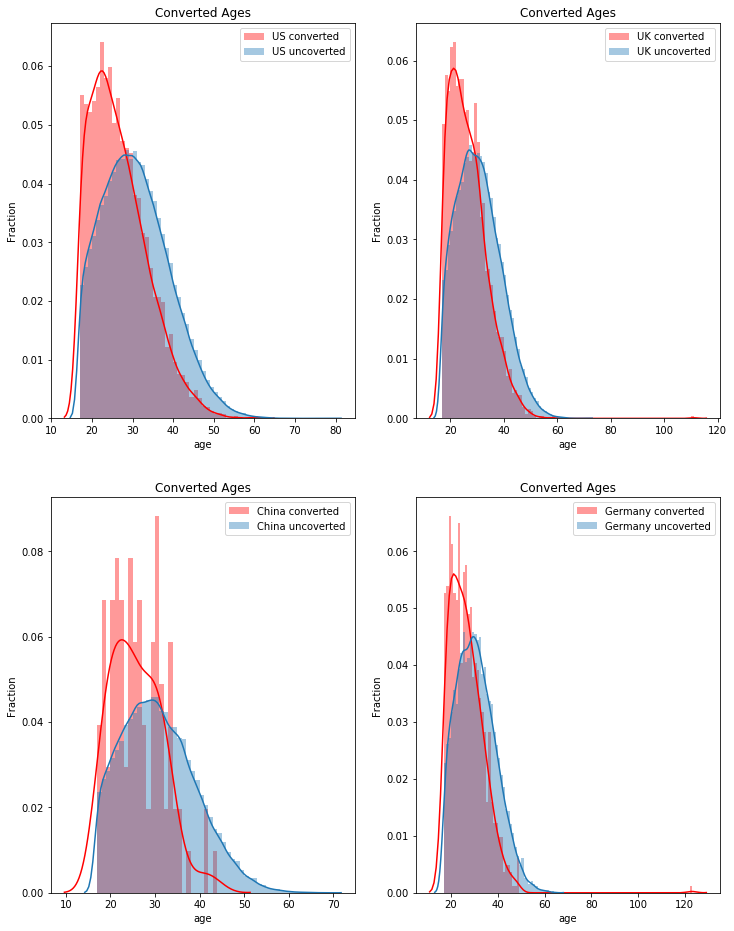

In [9]:
# Graphing the age distributions for converted and unconverted users, broken down by country
fig = plt.gcf()
fig.set_size_inches(12,16)
ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['age'].loc[(df['country'] == 'US')&(df['converted']==1)], bins=bins(df['age'].loc[(df['country']=='US')&(df['converted']==1)]),label='US converted', color = 'r')
sns.distplot(df['age'].loc[(df['country'] == 'US')&(df['converted']==0)], bins=bins(df['age'].loc[(df['country']=='US')&(df['converted']==0)]),label='US uncoverted')
ax1.set_ylabel('Fraction')
ax1.set_title('Converted Ages')
ax1.legend()
ax2 = fig.add_subplot(2,2,2)
sns.distplot(df['age'].loc[(df['country'] == 'UK')&(df['converted']==1)], bins=bins(df['age'].loc[(df['country']=='UK')&(df['converted']==1)]),label='UK converted', color = 'r')
sns.distplot(df['age'].loc[(df['country'] == 'UK')&(df['converted']==0)], bins=bins(df['age'].loc[(df['country']=='UK')&(df['converted']==0)]),label='UK uncoverted')
ax2.set_ylabel('Fraction')
ax2.set_title('Converted Ages')
ax2.legend()
ax3 = fig.add_subplot(2,2,3)
sns.distplot(df['age'].loc[(df['country'] == 'China')&(df['converted']==1)], bins=bins(df['age'].loc[(df['country']=='China')&(df['converted']==1)]),label='China converted', color = 'r')
sns.distplot(df['age'].loc[(df['country'] == 'China')&(df['converted']==0)], bins=bins(df['age'].loc[(df['country']=='China')&(df['converted']==0)]),label='China uncoverted')
ax3.set_ylabel('Fraction')
ax3.set_title('Converted Ages')
ax3.legend()
ax4 = fig.add_subplot(2,2,4)
sns.distplot(df['age'].loc[(df['country'] == 'Germany')&(df['converted']==1)], bins=bins(df['age'].loc[(df['country']=='Germany')&(df['converted']==1)]),label='Germany converted', color = 'r')
sns.distplot(df['age'].loc[(df['country'] == 'Germany')&(df['converted']==0)], bins=bins(df['age'].loc[(df['country']=='Germany')&(df['converted']==0)]),label='Germany uncoverted')
ax4.set_ylabel('Fraction')
ax4.set_title('Converted Ages')
ax4.legend()

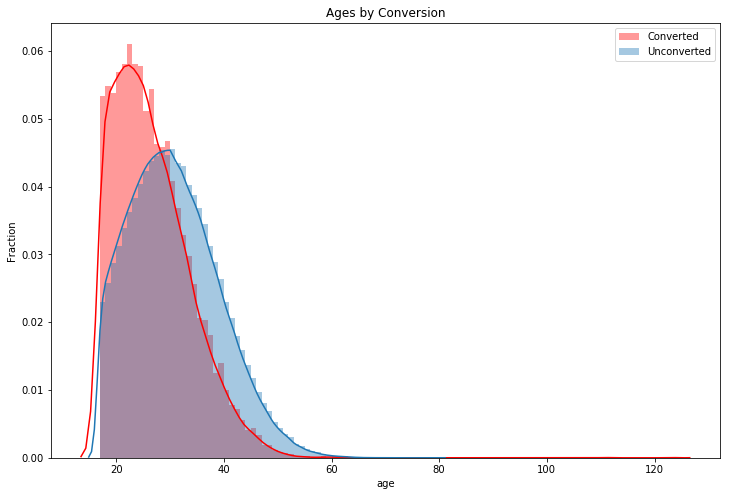

In [10]:
# Age distributions for converted and unconverted users for all countries combined
fig = plt.gcf()
fig.set_size_inches(12,8)
sns.distplot(df['age'].loc[(df['converted'] == 1)], bins = bins(df['age'].loc[df['converted']==1]),color='r',label='Converted')
sns.distplot(df['age'].loc[(df['converted'] == 0)], bins=bins(df['age'].loc[df['converted']==0]),label='Unconverted')
plt.ylabel('Fraction')
plt.title('Ages by Conversion')
plt.legend()



To a first approximation, the age of the customer is related to the likelihood of the customer making a purchase.  This looks to be fairly consistent across markets, however.  Let's see whether the conversion differs for each country based on how many pages the user visits.

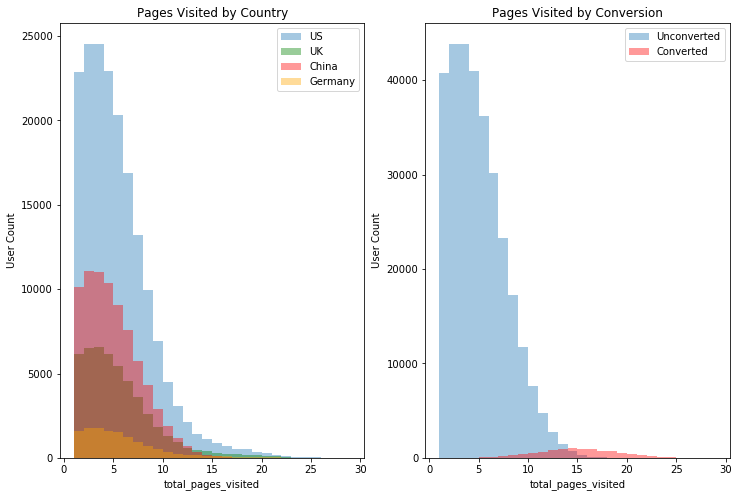

In [11]:
# total_pages_visited by country
fig = plt.gcf()
fig.set_size_inches(12,8)
ax1 = fig.add_subplot(1,2,1)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'US')], bins=bins(df['total_pages_visited'].loc[df['country']=='US']), kde=False,label='US')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'UK')], bins = bins(df['total_pages_visited'].loc[df['country']=='UK']),color='g', kde=False,label='UK')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'China')], bins = bins(df['total_pages_visited'].loc[df['country']=='China']),color='r', kde=False,label = 'China')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'Germany')], bins = bins(df['total_pages_visited'].loc[df['country']=='Germany']),color='orange', kde=False,label = 'Germany')
ax1.set_ylabel('User Count')
ax1.set_title('Pages Visited by Country')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
sns.distplot(df['total_pages_visited'].loc[(df['converted'] == 0)], bins=bins(df['total_pages_visited'].loc[df['converted']==0]),kde = False, label='Unconverted')
sns.distplot(df['total_pages_visited'].loc[(df['converted'] == 1)], bins = bins(df['total_pages_visited'].loc[df['converted']==1]),color='r',kde = False, label='Converted')
ax2.set_ylabel('User Count')
ax2.set_title('Pages Visited by Conversion')
ax2.legend()

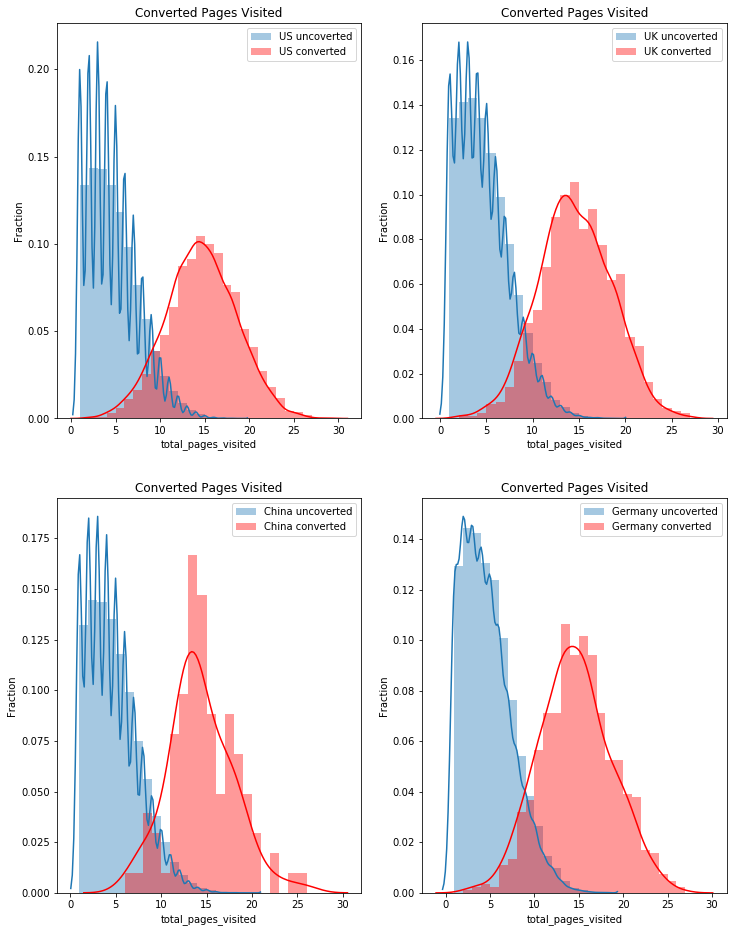

In [12]:
# total_pages_visited, broken down by country and whether they converted.

fig = plt.gcf()
fig.set_size_inches(12,16)
ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'US')&(df['converted']==0)], bins=bins(df['total_pages_visited'].loc[(df['country']=='US')&(df['converted']==0)]),label='US uncoverted')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'US')&(df['converted']==1)], bins=bins(df['total_pages_visited'].loc[(df['country']=='US')&(df['converted']==1)]),label='US converted', color = 'r')
ax1.set_ylabel('Fraction')
ax1.set_title('Converted Pages Visited')
ax1.legend()
ax2 = fig.add_subplot(2,2,2)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'UK')&(df['converted']==0)], bins=bins(df['total_pages_visited'].loc[(df['country']=='UK')&(df['converted']==0)]),label='UK uncoverted')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'UK')&(df['converted']==1)], bins=bins(df['total_pages_visited'].loc[(df['country']=='UK')&(df['converted']==1)]),label='UK converted', color = 'r')
ax2.set_ylabel('Fraction')
ax2.set_title('Converted Pages Visited')
ax2.legend()
ax3 = fig.add_subplot(2,2,3)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'China')&(df['converted']==0)], bins=bins(df['total_pages_visited'].loc[(df['country']=='China')&(df['converted']==0)]),label='China uncoverted')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'China')&(df['converted']==1)], bins=bins(df['total_pages_visited'].loc[(df['country']=='China')&(df['converted']==1)]),label='China converted', color = 'r')
ax3.set_ylabel('Fraction')
ax3.set_title('Converted Pages Visited')
ax3.legend()
ax4 = fig.add_subplot(2,2,4)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'Germany')&(df['converted']==0)], bins=bins(df['total_pages_visited'].loc[(df['country']=='Germany')&(df['converted']==0)]),label='Germany uncoverted')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'Germany')&(df['converted']==1)], bins=bins(df['total_pages_visited'].loc[(df['country']=='Germany')&(df['converted']==1)]),label='Germany converted', color = 'r')
ax4.set_ylabel('Fraction')
ax4.set_title('Converted Pages Visited')
ax4.legend()

Total pages visited also does not seem to indicate a substantial difference in behavior between markets.  There are last things I want to look at before I begin modeling, however.  It is the conversion rate based on new vs returning users and conversion rates based on origin, broken down by country.

   country  new_user   total  converted      rate
0    China         0   23094         66  0.002858
1    China         1   53508         36  0.000673
2  Germany         0    4214        589  0.139772
3  Germany         1    8842        227  0.025673
4       UK         0   15512       1774  0.114363
5       UK         1   32938        776  0.023559
6       US         0   56636       4732  0.083551
7       US         1  121456       2000  0.016467


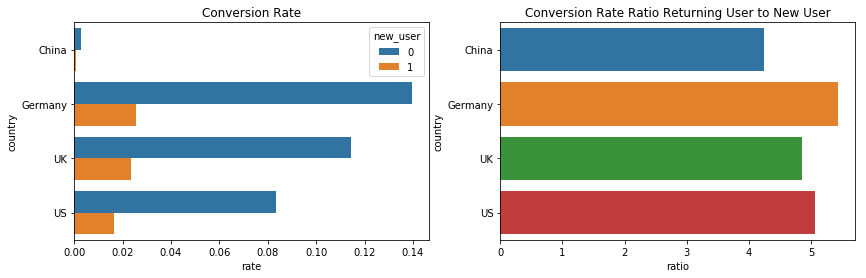

In [13]:
# Conversion rates by new or returning users, broken down by country
c_rate = pd.DataFrame()
gb = df.groupby(['country','new_user'])
c_rate = gb.agg({'age': 'count', 'converted': 'sum'}).rename(columns={'age':'total'})
c_rate.reset_index(inplace=True)
c_rate['rate']=(c_rate['converted']/c_rate['total'])
print c_rate

fig = plt.gcf()
fig.set_size_inches(14,4)
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x='rate',y='country', hue='new_user',data = c_rate)
ax1.set_title('Conversion Rate')

c_rate['ratio'] = c_rate['rate']/c_rate['rate'].shift(-1)
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x='ratio',y='country',data = c_rate.loc[c_rate['new_user']==0])
ax2.set_title('Conversion Rate Ratio Returning User to New User')

    country  source  total  converted      rate
0     China     Ads  21561         32  0.001484
1     China  Direct  17463         24  0.001374
2     China     Seo  37578         46  0.001224
3   Germany     Ads   3760        251  0.066755
4   Germany  Direct   2864        153  0.053422
5   Germany     Seo   6432        412  0.064055
6        UK     Ads  13518        752  0.055630
7        UK  Direct  11131        515  0.046267
8        UK     Seo  23801       1283  0.053905
9        US     Ads  49901       2025  0.040580
10       US  Direct  40962       1348  0.032909
11       US     Seo  87229       3359  0.038508


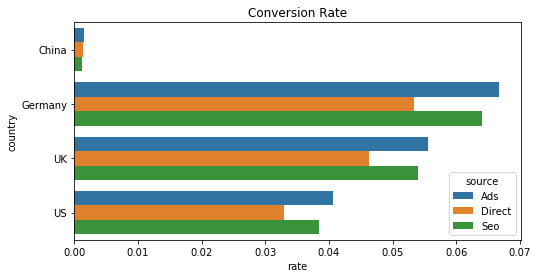

In [14]:
# conversion rate broken down by country and source
c_rate = pd.DataFrame()
gb = df.groupby(['country','source'])
c_rate = gb.agg({'age': 'count', 'converted': 'sum'}).rename(columns={'age':'total'})
c_rate.reset_index(inplace=True)
c_rate['rate']=(c_rate['converted']/c_rate['total'])
print c_rate

fig = plt.gcf()
fig.set_size_inches(8,4)
ax1 = fig.add_subplot(1,1,1)
sns.barplot(x='rate',y='country', hue='source',data = c_rate)
ax1.set_title('Conversion Rate')


This seems to be consistent with all of the other breakdowns, as well.  There apprears to be a small deficit in the SEO conversion rate in China, but other than that, user behavior seems to be pretty consistent across markets.  I think it's probably safest to model each market independently and then see if the same factors become predictive.  Of concern, the China market only has 102 total conversions.  The number of features that can be used for modeling is pretty small, though (6: age, new_user, total_pages_visited, and one-encoded sources), so it should be OK.

In [15]:
# OK, let's one-encode the source
test = pd.get_dummies(df['source'])
df = df.drop('source',axis=1)
df = df.join(test)
df.head()

,country,age,new_user,total_pages_visited,converted,Ads,Direct,Seo
0,UK,25,1,1,0,1,0,0
1,US,23,1,5,0,0,0,1
2,US,28,1,4,0,0,0,1
3,China,39,1,5,0,0,0,1
4,US,30,1,6,0,0,0,1


Random Forests shouldn't need to have scaled data, however it will need to be balanced.

In [16]:
country_data = collections.namedtuple('country_data',['X','y'])

# This function will split out a balanced data set for the given country_name
def data_by_country(data,country_name):
    #     find the number of converted users, randomly sample that number of unconverted users 
    #        & concatenate it to the converted users
    n_converted = data['converted'].loc[(data['converted']==1) & (data['country']==country_name)].size
    unconverted = data.loc[(data['converted']==0)&(data['country']==country_name)].sample(n_converted)
    X = pd.concat([data.loc[(data['converted']==1) & (data['country']==country_name)],unconverted])

    #     Now create y as the converted labels and drop that from the data
    y = X['converted']
    X = X.drop('converted',axis=1)
    X = X.drop('country',axis=1)
    
#     Return both as a tuple
    p=country_data(X=X,y=y)
    return p

,index,age,new_user,total_pages_visited,Ads,Direct,Seo
country,,,,,,,
UK,0,0.050674,0.102616,0.844894,0.000659,0.000545,0.000611
US,0,0.045928,0.133409,0.819291,0.000128,0.001010,0.000235
China,0,0.171847,0.081229,0.712911,0.013131,0.010283,0.010599
Germany,0,0.066353,0.132173,0.796209,0.001360,0.001447,0.002458


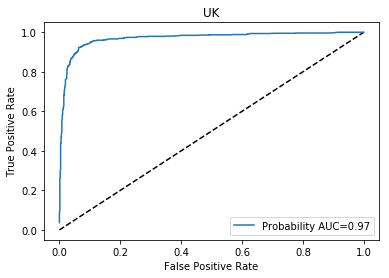

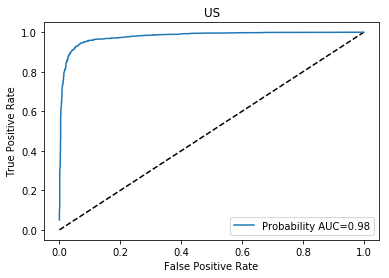

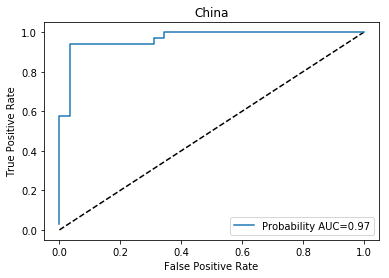

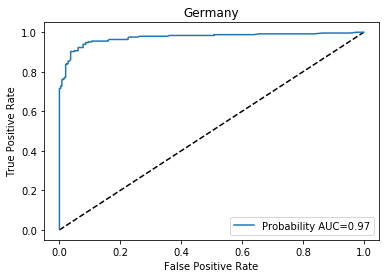

In [17]:
rf = RandomForestClassifier(n_estimators = 20,max_depth=4)
feature_weights = pd.DataFrame()
feature_weights_graph = pd.DataFrame()
prec_recall_f1 = pd.DataFrame()

# loop over the countries and do a random forest analysis on each
for country in df['country'].unique():
    country_spec_data = data_by_country(df,country)
    X = country_spec_data.X
    y = country_spec_data.y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf.fit(X_train,y_train)

#     This section tests the model and assembles dataframes containing the feature weights and statistics
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr,tpr)
    temp = pd.DataFrame(rf.feature_importances_).transpose()
    temp.insert(0,'country',country)
    feature_weights = feature_weights.append(temp)
    temp = pd.DataFrame()
    temp = temp.append(list(df.columns.drop(['country','converted'])))
    temp['weights']=pd.DataFrame(rf.feature_importances_)
    temp.insert(0,'country',country)
    temp.columns=['country','feature','weight']
    feature_weights_graph = feature_weights_graph.append(temp)
    temp = pd.DataFrame([country,precision_score(y_test,y_pred),recall_score(y_test,y_pred),f1_score(y_test,y_pred)]).transpose()
    temp.columns=['Country','Precision','Recall','F1']
    prec_recall_f1 = prec_recall_f1.append(temp)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Probability AUC=%0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(country)
    plt.legend(loc='lower right')

feature_weights.columns=[df.columns.drop('converted')]
feature_weights.reset_index(inplace=True)
feature_weights.set_index('country')

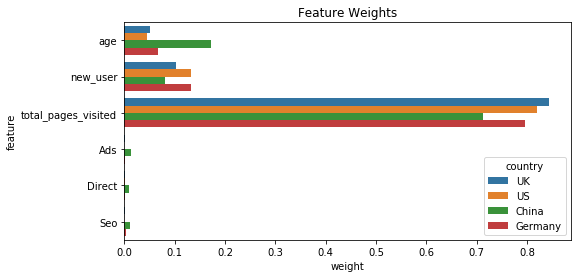

In [18]:
fig = plt.gcf()
fig.set_size_inches(8,4)
ax1 = fig.add_subplot(1,1,1)
sns.barplot(y='feature', x='weight', hue = 'country',data = feature_weights_graph)
ax1.set_title('Feature Weights')

In [19]:
prec_recall_f1

,Country,Precision,Recall,F1
0,UK,0.917197,0.936281,0.926641
0,US,0.938462,0.934289,0.93637
0,China,0.911765,0.939394,0.925373
0,Germany,0.936975,0.906504,0.921488


# Conclusions
There are several interesting aspects in the data. The challenge first asked to see whether it could be predicted whether or not a user would convert.  The answer to that in an astounding YES!  
The precision, recall and F1 scores for the random forest are very high in all cases.
For every market, the three predictors are:
 ##### 1) total_pages_visited 
 ##### 2) whether or not it was a new_user
 ##### 3) the self-reported age of the user

Total_pages_visited is by far the most influential feature.  Interestingly, in the case of the Chinese market, age is the second most predictive rather than the new_user status.  This is the opposite in the other three markets.

Another interesting note is that across all markets, the users who convert seem to have fairly similar behavior and profiles: younger in age, more likley to be a returning user and spend more time on the site.

### Suggestions for increasing conversion

The biggest potential gain is in the Chinese market.  The profiles of users in China who convert is similar to those in the other markets (younger, returning, staying longer).  
The average age of user is the same as the other markets, as is the conversion ratio for new to returning users. This indicates that the biggest problem is that most users in China, for some reason, do not spend very long on the site.  And that is by far the number one predictor of conversion. This discrepency can be seen in the reduced high end tail of the histogram of total pages visited (see below).  
The Chinese market is the second largest after the US.  If the company can get users in that market to stay on the site longer, their overall conversion rate will see the biggest jump.  The company should investigate whether there is something wrong (bad translation, poor rendering, slow loading, etc...) with the chinese version of the site and potentially tweak it for that market.

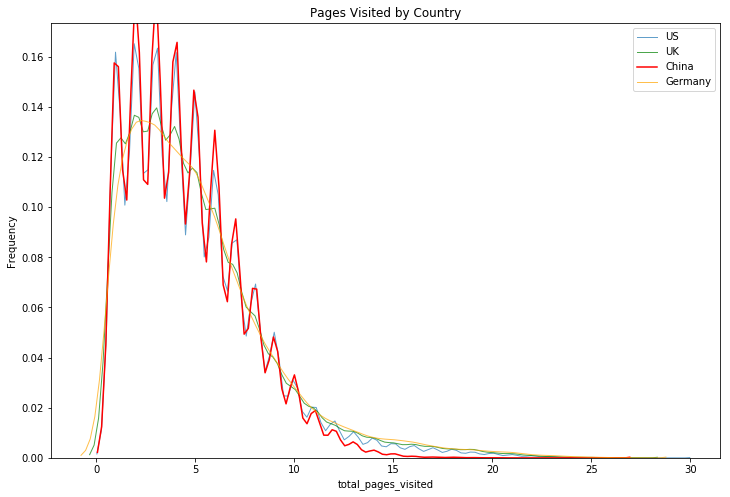

In [20]:
fig = plt.gcf()
fig.set_size_inches(12,8)
# ax1 = fig.add_subplot(1,2,1)
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'US')], bins=bins(df['total_pages_visited'].loc[df['country']=='US']), kde_kws={"lw": 1, "alpha":0.7}, hist=False,label='US')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'UK')], bins = bins(df['total_pages_visited'].loc[df['country']=='UK']),color='g', kde_kws={"lw": 1, "alpha":0.7},hist=False,label='UK')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'China')], bins = bins(df['total_pages_visited'].loc[df['country']=='China']),color='r', hist=False,label = 'China')
sns.distplot(df['total_pages_visited'].loc[(df['country'] == 'Germany')], bins = bins(df['total_pages_visited'].loc[df['country']=='Germany']),color='orange', kde_kws={"lw": 1, "alpha":0.7},hist=False,label = 'Germany')
plt.ylabel('Frequency')
plt.title('Pages Visited by Country')
plt.legend()